In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import pandas as pd

ddir = '/share/PI/sabatti/sc_data/spatial_ge/spatialde/SpatialDE/Analysis/SeqFISH/'
fn = ddir + 'mmc6.xlsx'
exp_mat = pd.read_excel(fn, 0, header=None, index_col=0)
print(exp_mat.shape)
field_vector = pd.read_excel(fn, 1, header=None).T
field_vector.index += 1
field_vector.columns = ['field']
print(field_vector.shape)
sample_info = pd.read_excel(fn, 2, header=None)
sample_info.index += 1
sample_info.columns= ['x', 'y', 'z']
print(sample_info.shape)
sample_info = sample_info.join(field_vector)
sample_info['total_count'] = exp_mat.sum(0)

(249, 3585)
(3585, 1)
(3585, 3)


In [3]:
sample_info.head()

,x,y,z,field,total_count
1,490,760,2,33,6131
2,98,532,3,33,4040
3,872,570,3,33,5352
4,936,590,3,33,5623
5,432,722,3,33,4440


In [4]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

raw data dim: (1056, 140)


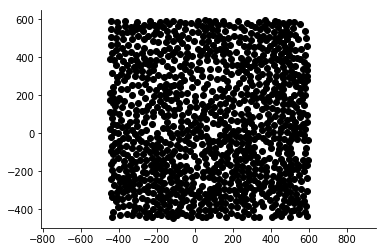

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MERFISH/our_results/MERFISH_result_df.csv
Selected: 134


In [16]:
from io_utils import save_data_to_file, load_data_from_file
from general_utils import read_spatial_expression, normalize_count_cellranger
from main_methods import select_spatial_genes
from matplotlib_venn import venn2,venn3
   
# load the data for a given replicate
ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
locs,data=read_spatial_expression(ff,sep=' ')
data_norm = normalize_count_cellranger(data)
# data_norm = data

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.scatter(*locs.T, c='k')
plt.axis('equal')
plt.show()
alpha= 0.05

# run our method
fn =  ddir+'/data/MERFISH/our_results/MERFISH_result_df.csv'
pvals, rej_idx = select_spatial_genes(locs, data_norm.values, knn=6, alpha=alpha, n_perm=10000)
ours = data.columns[rej_idx]
reject = np.array([False] * len(pvals))
reject[rej_idx] = True
result = pd.DataFrame({'pvalue': pvals, 'reject': reject, 'geneID':data_norm.columns})
# save result to file
save_data_to_file(result, fn, 'csv')        
print('Saved: {}'.format(fn))
print('Selected: {}'.format(ours.shape[0]))

In [17]:
load_data_from_file(fn, 'csv').head()

,pvalue,reject,geneID
0,0.0001,True,AFAP1
1,0.0001,True,AFF4
2,0.0001,True,AGAP1
3,0.0001,True,AGO3
4,0.0001,True,AGPS


In [9]:
fileName = ddir + "/data/MERFISH/scGCO_results/MERFISH_result_df.csv"
result_df = pd.read_csv(fileName, index_col=0)
fdr05 = result_df[result_df.fdr < alpha].sort_values(by=['fdr'])
print(fdr05.shape)

(84, 1052)


In [10]:
de = ddir + "/data/MERFISH/spatialDE_results/middle_final_results.csv"
counts_de = pd.read_csv(de,index_col=0)
counts_de=counts_de[counts_de.qval<alpha]
counts_de=counts_de[counts_de.g.values != 'log_total_count']
print(counts_de.shape[0])

91


In [11]:
gsets = {
        'scGCO': set(fdr05.index.values),
        'SpatialDE': set(counts_de.g.values),
        'Ours': set(data_norm.columns[rej_idx])
    }

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


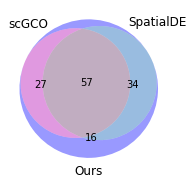

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plot_venn3(gsets, ax)
plt.show()